In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf

In [95]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 100000

In [96]:
# generate steps for all particles
steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))

In [97]:
# initial positions
x = 2*L*np.random.random(size=(N,))

In [98]:
# put initial position in front
x = np.column_stack((x, steps))

In [99]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),2*L)-L

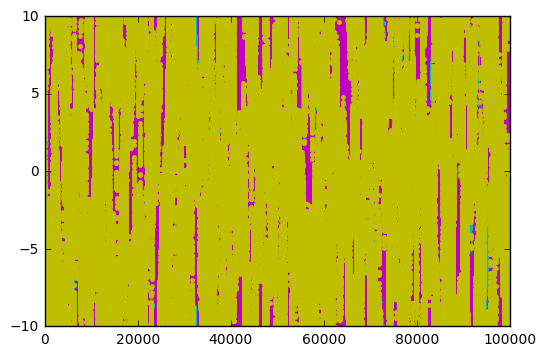

In [100]:
for path in paths:
    plt.plot(path,".")

In [101]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=0)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

1.02435504981
1.0


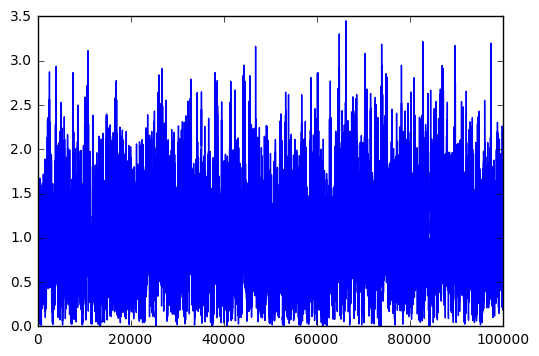

In [102]:
plt.plot(intensity)
print(intensity.mean())
# what should it be
print(N/2/L)

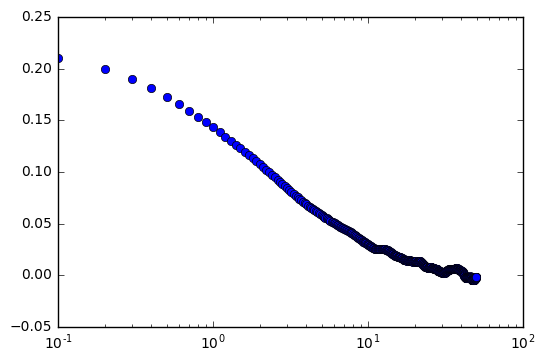

In [103]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:500]-1.0
t = np.arange(0,autocorr.size)*dt
plt.semilogx(t,autocorr,"o")

In [104]:
print(autocorr[0]/N*L)
print(L/autocorr[0]/N)
print(autocorr[0]*N/L*2*np.sqrt(np.pi))
print(L/autocorr[0]/N/np.sqrt(np.pi))

0.111681664583
2.23850531718
1.58360477172
1.26294138267


In [105]:
# this is the model that describes the ideal case if infinite boundary conditions
def corrfit(t,N,D,w0):
    return 1/N/np.sqrt(1+(D*t/w0**2))

In [106]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 80
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [107]:
corrfitPB_model=lm.Model(corrfitPB)
paramsPB = corrfitPB_model.make_params()
paramsPB['w0'].set(value=1,vary=False)
paramsPB['N'].set(value=20,vary=True)
paramsPB['D'].set(value=D,vary=True)
paramsPB['L'].set(value=L,vary=False)

resultPB = corrfitPB_model.fit(t=t,data=autocorr,params=paramsPB)

In [108]:
print(resultPB.fit_report())

[[Model]]
    Model(corrfitPB)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.003
    reduced chi-square = 0.000
    Akaike info crit   = -6000.943
    Bayesian info crit = -5992.514
[[Variables]]
    N:    20.8818627 +/- 0.089725 (0.43%) (init= 20)
    D:    1.04189162 +/- 0.007168 (0.69%) (init= 1)
    w0:   1 (fixed)
    L:    10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.776 



In [109]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=1,vary=False)
params['N'].set(value=5,vary=True)
params['D'].set(value=1,vary=True)

result = corrfit_model.fit(t=t,data=autocorr,params=params)

In [110]:
print(result.fit_report())

[[Model]]
    Model(corrfit)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 0.121
    reduced chi-square = 0.000
    Akaike info crit   = -4157.369
    Bayesian info crit = -4148.940
[[Variables]]
    N:    3.65125691 +/- 0.179678 (4.92%) (init= 5)
    D:    6.49972284 +/- 0.766469 (11.79%) (init= 1)
    w0:   1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.927 



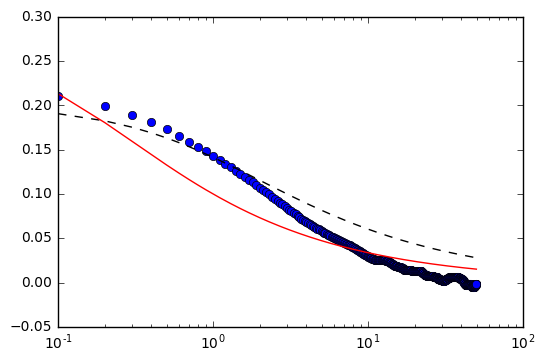

In [111]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')

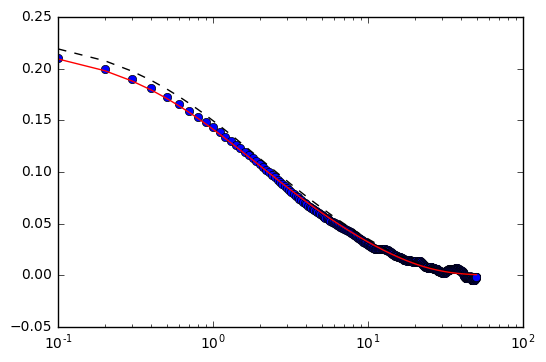

In [112]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, resultPB.init_fit, 'k--')
plt.semilogx(t, resultPB.best_fit, 'r-')